<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0110ENSkillsNetwork952-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


<h1>Logistic Regression Training Negative Log likelihood (Cross-Entropy)</h1> 


<h2>Objective</h2><ul><li> How Cross-Entropy using random initialization influence the accuracy of the model.</li></ul> 


<h2>Table of Contents</h2>
<p>In this lab, you will see what happens when you use the Cross-Entropy or total loss function using random initialization for a parameter value.</p>

<ul>
    <li><a href="#Makeup_Data">Make Some Data</a></li>
    <li><a href="#Model_Cost">Create the Model and Cost Function the PyTorch way </a></li>
    <li><a href="#BGD">Train the Model: Batch Gradient Descent</a></li>
</ul>
<p>Estimated Time Needed: <strong>30 min</strong></p>

<hr>


<h2>Preparation</h2>


We'll need the following libraries:


In [1]:
# Import the libraries we need for this lab

import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits import mplot3d
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

The class <code>plot_error_surfaces</code> is just to help you visualize the data space and the parameter space during training and has nothing to do with Pytorch. 


In [2]:
# Create class for plotting and the function for plotting

class plot_error_surfaces(object):
    
    # Construstor
    def __init__(self, w_range, b_range, X, Y, n_samples = 30, go = True):
        W = np.linspace(-w_range, w_range, n_samples)
        B = np.linspace(-b_range, b_range, n_samples)
        w, b = np.meshgrid(W, B)    
        Z = np.zeros((30, 30))
        count1 = 0
        self.y = Y.numpy()
        self.x = X.numpy()
        for w1, b1 in zip(w, b):
            count2 = 0
            for w2, b2 in zip(w1, b1):
                yhat= 1 / (1 + np.exp(-1*(w2*self.x+b2)))
                Z[count1,count2]=-1*np.mean(self.y*np.log(yhat+1e-16) +(1-self.y)*np.log(1-yhat+1e-16))
                count2 += 1   
            count1 += 1
        self.Z = Z
        self.w = w
        self.b = b
        self.W = []
        self.B = []
        self.LOSS = []
        self.n = 0
        if go == True:
            plt.figure()
            plt.figure(figsize=(7.5, 5))
            plt.axes(projection='3d').plot_surface(self.w, self.b, self.Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
            plt.title('Loss Surface')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.show()
            plt.figure()
            plt.title('Loss Surface Contour')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.contour(self.w, self.b, self.Z)
            plt.show()
            
     # Setter
    def set_para_loss(self, model, loss):
        self.n = self.n + 1
        self.W.append(list(model.parameters())[0].item())
        self.B.append(list(model.parameters())[1].item())
        self.LOSS.append(loss)
    
    # Plot diagram
    def final_plot(self): 
        ax = plt.axes(projection='3d')
        ax.plot_wireframe(self.w, self.b, self.Z)
        ax.scatter(self.W, self.B, self.LOSS, c='r', marker='x', s=200, alpha=1)
        plt.figure()
        plt.contour(self.w, self.b, self.Z)
        plt.scatter(self.W, self.B, c='r', marker='x')
        plt.xlabel('w')
        plt.ylabel('b')
        plt.show()
        
    # Plot diagram
    def plot_ps(self):
        plt.subplot(121)
        plt.ylim
        plt.plot(self.x, self.y, 'ro', label="training points")
        plt.plot(self.x, self.W[-1] * self.x + self.B[-1], label="estimated line")
        plt.plot(self.x, 1 / (1 + np.exp(-1 * (self.W[-1] * self.x + self.B[-1]))), label='sigmoid')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.ylim((-0.1, 2))
        plt.title('Data Space Iteration: ' + str(self.n))
        plt.show()
        plt.subplot(122)
        plt.contour(self.w, self.b, self.Z)
        plt.scatter(self.W, self.B, c='r', marker='x')
        plt.title('Loss Surface Contour Iteration' + str(self.n))
        plt.xlabel('w')
        plt.ylabel('b')
        
# Plot the diagram

def PlotStuff(X, Y, model, epoch, leg=True):
    plt.plot(X.numpy(), model(X).detach().numpy(), label=('epoch ' + str(epoch)))
    plt.plot(X.numpy(), Y.numpy(), 'r')
    if leg == True:
        plt.legend()
    else:
        pass

Set the random seed:


In [3]:
# Set random seed

torch.manual_seed(0)

<!--Empty Space for separating topics-->


<h2 id="Makeup_Data">Get Some Data</h2>


In [4]:
# Create the data class

class Data(Dataset):
    
    # Constructor
    def __init__(self):
        self.x = torch.arange(-1, 1, 0.1).view(-1, 1)
        self.y = torch.zeros(self.x.shape[0], 1)
        self.y[self.x[:, 0] > 0.2] = 1
        self.len = self.x.shape[0]
    
    # Getter
    def __getitem__(self, index):      
        return self.x[index], self.y[index]
    
    # Get length
    def __len__(self):
        return self.len

Make <code>Data</code> object


In [5]:
# Create Data object

data_set = Data()

<!--Empty Space for separating topics-->


<h2 id="Model_Cost">Create the Model and Total Loss Function (Cost)</h2>


Create a custom module for logistic regression:


In [6]:
# Create logistic_regression class

class logistic_regression(nn.Module):
    
    # Constructor
    def __init__(self, n_inputs):
        super(logistic_regression, self).__init__()
        self.linear = nn.Linear(n_inputs, 1)
        
    # Prediction
    def forward(self, x):
        yhat = torch.sigmoid(self.linear(x))
        return yhat

Create a logistic regression object or model: 


In [7]:
# Create the logistic_regression result

model = logistic_regression(1)

Replace the random initialized variable values. Theses random initialized variable values did convergence for the RMS Loss but will converge for the Cross-Entropy Loss.


In [8]:
# Set the weight and bias

model.state_dict() ['linear.weight'].data[0] = torch.tensor([[-5]])
model.state_dict() ['linear.bias'].data[0] = torch.tensor([[-10]])
print("The parameters: ", model.state_dict())

The parameters:  OrderedDict([('linear.weight', tensor([[-5.]])), ('linear.bias', tensor([-10.]))])


Create a <code> plot_error_surfaces</code> object to visualize the data space and the parameter space during training:


<Figure size 432x288 with 0 Axes>

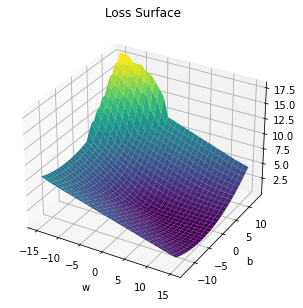

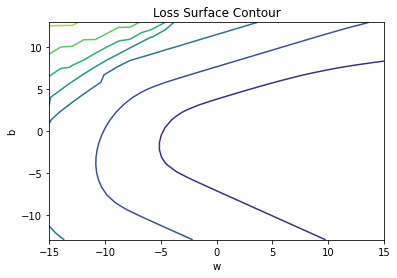

In [9]:
# Create the plot_error_surfaces object

get_surface = plot_error_surfaces(15, 13, data_set[:][0], data_set[:][1], 30)

Define the cost or criterion function: 


In [10]:
# Create dataloader, criterion function and optimizer

def criterion(yhat,y):
    out = -1 * torch.mean(y * torch.log(yhat) + (1 - y) * torch.log(1 - yhat))
    return out

# Build in criterion
# criterion = nn.BCELoss()

trainloader = DataLoader(dataset = data_set, batch_size = 3)
learning_rate = 2
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

<!--Empty Space for separating topics-->


<h2 id="BGD">Train the Model via Batch Gradient Descent</h2>


Train the model


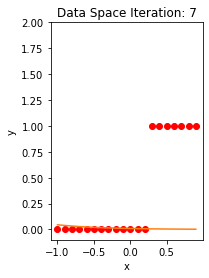

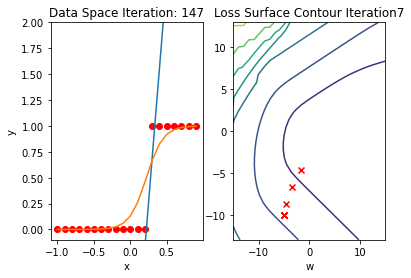

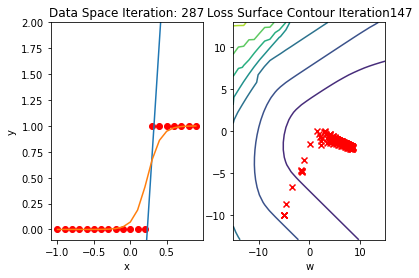

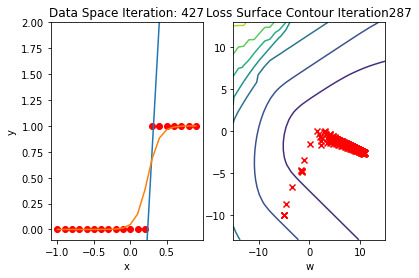

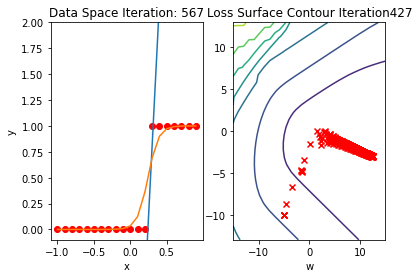

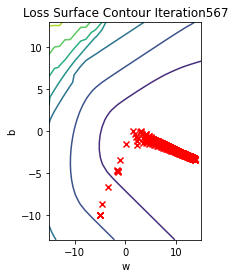

In [11]:
# Train the Model

def train_model(epochs):
    for epoch in range(epochs):
        for x, y in trainloader:
            yhat = model(x)
            loss = criterion(yhat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            get_surface.set_para_loss(model, loss.tolist())
        if epoch % 20 == 0:
            get_surface.plot_ps()
            
train_model(100)

Get the actual class of each sample and calculate the accuracy on the test data:


In [12]:
# Make the Prediction

yhat = model(data_set.x)
label = yhat > 0.5
print("The accuracy: ", torch.mean((label == data_set.y.type(torch.ByteTensor)).type(torch.float)))

The accuracy:  tensor(1.)


The accuracy is perfect.



<a href="https://dataplatform.cloud.ibm.com/registration/stepone?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0110ENSkillsNetwork952-2022-01-01&context=cpdaas&apps=data_science_experience%2Cwatson_machine_learning"><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0110EN-SkillsNetwork/Template/module%201/images/Watson_Studio.png"></a>



<!--Empty Space for separating topics-->


<h2>About the Authors:</h2> 

<a href="https://www.linkedin.com/in/joseph-s-50398b136/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0110ENSkillsNetwork952-2022-01-01">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD. 


Other contributors: <a href="https://www.linkedin.com/in/michelleccarey/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0110ENSkillsNetwork952-2022-01-01">Michelle Carey</a>, <a href="www.linkedin.com/in/jiahui-mavis-zhou-a4537814a">Mavis Zhou</a>



## Change Log

|  Date (YYYY-MM-DD) |  Version | Changed By  |  Change Description |
|---|---|---|---|
| 2020-09-23  | 2.0  | Shubham  |  Migrated Lab to Markdown and added to course repo in GitLab |



<hr>


## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>
